# Import

In [1]:
'''
    通过 mindquantum 计算对易式 commutator
'''
import numpy as np    
import networkx as nx
from mindquantum.core.operators import QubitOperator, commutator
from openqaoa.problems import MaximumCut
from openqaoa.utilities import plot_graph
from openqaoa.utilities import ground_state_hamiltonian
import copy
import random
import re

In [2]:
'''
    提示：因为要求使用 mindquantum==0.9.0 但 stabilizer Simulator 功能尚不完善
    所以通过 stim 来模拟 clifford 线路并求相关期望值
'''
import stim

# Functions

In [17]:
'''
   构建问题的哈密顿量，Hc = 1/2 ∑(wZZ)
   qubo 是通过 openqaoa.problems 的 MaximumCut 生成的 maxcut graph
   通过 mindquantum 构建
   通过 stim 构建
   通过 sim.peek_observable_expectation 对线路求期望
'''
def hamil_mq(qubo):
    def hamil_str(pos):
        result = f'Z{pos[0]} Z{pos[1]}'
        return result
    hamil_op = QubitOperator()
    for index,term in enumerate(qubo.terms):
        hamil_op += QubitOperator(hamil_str(term), qubo.weights[index]/2) 
    return hamil_op

def hamil_st(qubo):
    ham_str = []
    for [i,j] in qubo.terms:
        ham_str.append(f'Z{i}*Z{j}')
    return ham_str

def Expectation(qubo,circ):
    sim = stim.TableauSimulator()
    sim.do(circ)
    
    exp_sin = [sim.peek_observable_expectation(stim.PauliString(term)) for term in hamil_st(qubo)]
    exp = sum([exp_sin[i]*qubo.weights[i]/2 for i in range(len(qubo.weights))])
    return exp

In [4]:
'''
    辅助工具
'''
def extract_and_replace(text):
    start = text.find('[') + 1
    end = text.find(']')
    if start > 0 and end > start:
        substring = text[start:end]
        result = substring.replace(' ', '*')
        return result
    return None

In [5]:
'''
   求 [Hc,Ac] 对当前线路的期望值 -i <ψ| [Hc,Ac] |ψ>
   先通过 mindquantum 求对易式，然后用 split 分解，因为 stim 只支持单个哈密顿量的期望求解。我们只能逐个然后求和
'''
def derivative(qubo, mixer, circ):
    commu = (-1j) * commutator(hamil_mq(qubo), QubitOperator(mixer))
    
    con = []
    ele = []
    for i,j in commu.split():
        con.append(i.const.real)
        ele.append(extract_and_replace(str(j)))

    val = []
    for string in ele:
        sim = stim.TableauSimulator()
        sim.do(circ)
        val.append(sim.peek_observable_expectation(stim.PauliString(string)))
    
    result = sum([con[i]*val[i] for i in range(len(con))])
        
    return result

In [6]:
'''
    初始化线路
'''
def init(nodes,t):
    circ = stim.Circuit()
    for i in range(nodes):
        circ.append('H',[i])
    circ.append('Z',[t])
    return circ

In [7]:
'''
    当 l < m, 作用 exp(-i θ/2 (Y⊗Z) )
    当 l > m, 作用 exp(-i θ/2 (Z⊗Y) )
'''
def add_layer(circ,l,m):
    circ.append('S_DAG',[l])
    circ.append('H',[m])
    circ.append('CNOT',[l,m])
    
    circ.append('Z',[l])
    circ.append('H_YZ',[l])
    
    circ.append('CNOT',[l,m])
    circ.append('S',[l])
    circ.append('H',[m])
    return circ

In [8]:
'''
    辅助工具
'''
def extract_numbers(s):
    match = re.match(r'(\D+)(\d+) (\D+)(\d+)', s)
    if match:
        # 提取匹配的数字部分
        n = int(match.group(2))
        m = int(match.group(4))
        return n, m

In [12]:
'''
   用 MaximumCut 接口生成自定义的 maxcut graph
   qubo.weights 和 qubo.terms 可以获取该 graph 的权重列表和连线列表
   只提供 uniform 权重分布
   draw_graph: 图的绘制
'''
def graph_complete(nodes):
    G = nx.complete_graph(nodes)
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = np.random.uniform(0, 1)
    return MaximumCut(G).qubo

def draw_graph(qubo):
    G = nx.Graph()
    for edge, weight in zip(qubo.terms, qubo.weights):
        G.add_edge(edge[0], edge[1], weight=weight)
    plot_graph(G)

# Adapt Clifford Algorithm

In [10]:
'''
    t: 随机初试值
    第一层的 mixers: Ya Zb, 后面的 mixers: Za Yb
    ADAPT-Clifford 分为 randomized 和 deterministic 方法
        randomized: 随机一个初始值 t
        deterministic: 所有初试值都尝试一遍，然后取最小的期望值
'''
def adapt_clifford(nodes, t, qubo):
    all_num = list(range(nodes))
    l = 0
    
    a = [t]
    b = [n for n in all_num if n!= t]
    mixers = [f'Y{i} Z{j}' for i in a for j in b]

    circ = init(nodes,t)

    while True:
        gradients = []
        for mixer in mixers:
            gradients.append(derivative(qubo, mixer, circ))
        mix = mixers[np.argmax(gradients)]

        if l == 0:
            k,j=extract_numbers(mix)
            circ = add_layer(circ,k,j)
        if l > 0:
            k,j=extract_numbers(mix)
            circ = add_layer(circ,j,k)
        
        a.append(j)
        b.remove(j)
        
        mixers = [f'Z{i} Y{j}' for i in a for j in b]
        l += 1
        if l == nodes - 1:
            return circ

def deterministic(qubo,nodes):
    EXPEC = []
    for i in range(nodes):
        circ = adapt_clifford(nodes, i, qubo)
        exp = Expectation(qubo,circ)

        EXPEC.append(exp)      
    return min(EXPEC),circ
        
def randomized(qubo,nodes):
    t = random.choice(list(range(nodes)))

    circ = adapt_clifford(nodes,t,qubo)
    exp = Expectation(qubo,circ)

    return exp, circ

# Set Test Problem

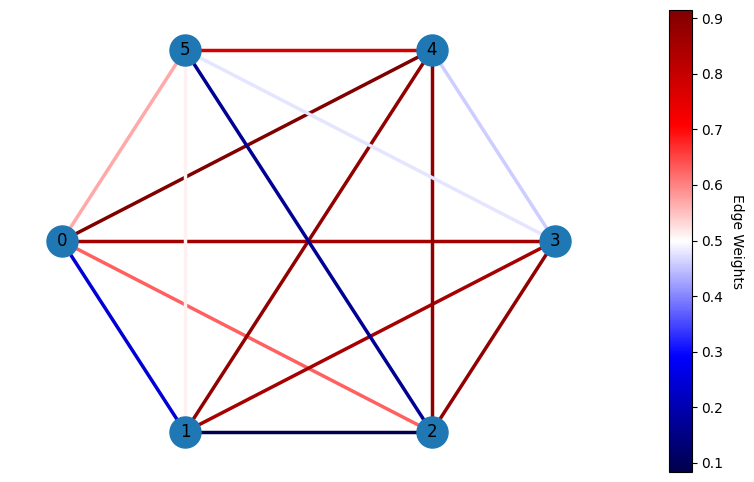

In [13]:
NODES = 6
qubo = graph_complete(NODES)
draw_graph(qubo)

In [20]:
%%time
energy_r, circ_r = randomized(qubo,NODES)
print(energy_r)

-1.9298199441910062
CPU times: total: 93.8 ms
Wall time: 82 ms


In [21]:
%%time
energy_d, circ_d = deterministic(qubo,NODES)
print(energy_d)

-1.9298199441910062
CPU times: total: 484 ms
Wall time: 482 ms


In [22]:
%%time
energy, configuration = ground_state_hamiltonian(qubo.hamiltonian)
print(energy/2)

-1.9298199441910062
CPU times: total: 15.6 ms
Wall time: 4 ms
